# RTF Model for predicting zone with Peaks


### Model Description
This notebook implements a Random Forest (RTF) model to classify the impact zone (C, S, V) of a racket using peak-based spectral features extracted from .wav audio files. The workflow includes reading the audio data, computing the frequency spectrum using FFT, and extracting the N most prominent peaks (both their frequencies and amplitudes) within a target range (150 Hz to 1000 Hz). These peak features are normalized and padded to ensure consistent dimensionality across samples. The resulting features are then used to train a Random Forest classifier. A grid search is performed over key hyperparameters such as the number of trees, depth, and minimum samples for splitting to assess model performance. The approach captures the most salient spectral components of each sound, making it suitable for characterizing impact zones in racket sports.

# Import Libraries

In [12]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys
from sklearn.ensemble import RandomForestClassifier


### Import Tools Functions

In [13]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Readwav function

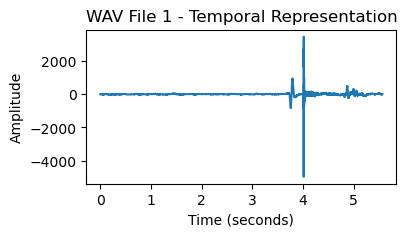

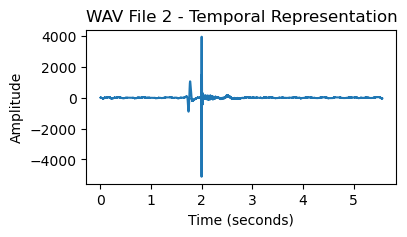

In [14]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

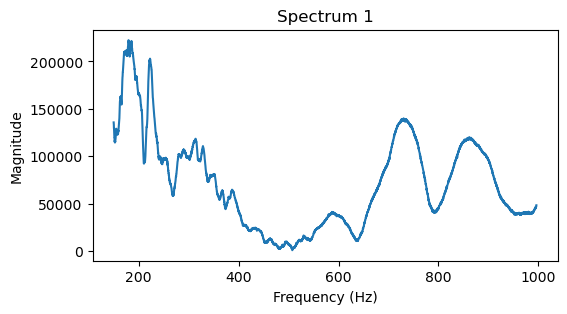

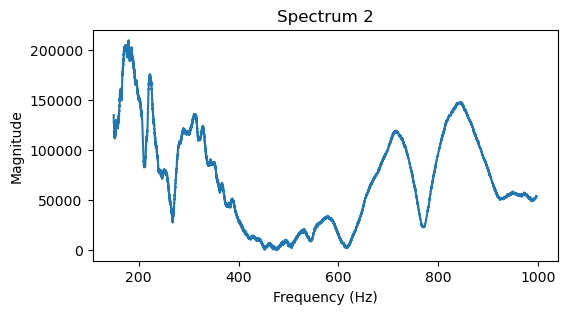

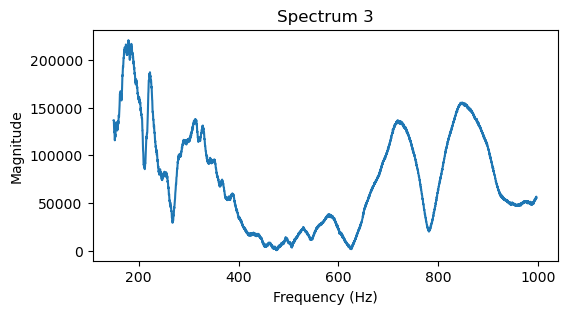

In [15]:
from spectrumFromSignal import spectrumFromSignal


spectrumVect=[]

for i in range(len(testWavFileVect)):
    spectrum,freqs= spectrumFromSignal(testWavFileVect[i],samplerateVect[i])
    spectrumVect.append(spectrum)

for idx, spectrum in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs[:len(spectrum)], spectrum)  # Associate frequencies with the spectrum
    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()



Peaks

In [16]:
from extractPeakFromSignal import extractPeakFromSignal

# Main

### Data Preparation and Label Encoding

In [17]:

from readWavFolder import readWavFolder
from spectrumFromWav import spectrumFromWav
from extractPeakFromSignal import extractPeakFromSignal
import re

# Liste des types de raquettes et zones
racket_names = {"RB": 1, "RO": 2, "RR": 3, "RV": 4}
zone_names = {"C": 1, "S": 2, "V": 3}

results = []

n_peak = 10  # Nombre de pics à extraire
c = 0       # Canal utilisé : 0 pour gauche, 1 pour droite


for band_width in range(20, 21, 5):
    X_peaksHz = []
    X_peaksAmplitude = []
    Y_Label = []

    print("band width :", band_width)

    for raquetteType in racket_names:
        dossier_raquette = f"../../../Data/Sound/P1"
        samplerateVect, WavFileVect, filesName = readWavFolder(dossier_raquette)

        for i in range(len(WavFileVect)):
            
            filename = filesName[i]

            # Utilisation de regex pour extraire la zone
            match = re.search(r'_(C|S|V)_', filename)
            if match:
                zone = match.group(1)
            else:
                continue  # Fichier ignoré s'il ne contient pas une zone valide

            wav_data = WavFileVect[i]

            # Gérer mono/stéréo sans modifier les fonctions
            if wav_data.ndim == 1:
                wav_data = np.stack((wav_data, wav_data), axis=-1)
            elif wav_data.shape[1] == 1:
                wav_data = np.concatenate((wav_data, wav_data), axis=1)

            spectrum = spectrumFromWav(wav_data)

            freqs = np.fft.fftfreq(len(spectrum) * 2, d=1 / samplerateVect[i])[:len(spectrum)]
            mask = (freqs >= 150) & (freqs <= 1000)
            filtered_freqs = freqs[mask]
            filtered_spectrum = spectrum[mask]

            # Extraire les pics correctement
            peaks_idx, properties = extractPeakFromSignal(filtered_spectrum, smoothing=100, num_peaks=n_peak)

            peaks = filtered_freqs[peaks_idx]
            peak_values = properties["peak_heights"]
            
            X_peaksHz.append(peaks)
            X_peaksAmplitude.append(peak_values)
            Y_Label.append(zone)

    # Normalisation des amplitudes
    new_X_peaksAmplitude = X_peaksAmplitude.copy()

    X_peaksAmplitude = [
        amp / np.max(amp) if np.max(amp) != 0 else amp
        for amp in X_peaksAmplitude
    ]

    # Padding
    max_length = max(
        max(len(peaks) for peaks in X_peaksHz),
        max(len(amps) for amps in X_peaksAmplitude)
    )
    X_peaksHz_padded = [np.pad(peaks, (0, max_length - len(peaks)), constant_values=0) for peaks in X_peaksHz]
    X_peaksAmplitude_padded = [np.pad(amps, (0, max_length - len(amps)), constant_values=0) for amps in X_peaksAmplitude]

    X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None, shuffle=True
    )

    n_estimators_range = range(10, 101, 10)
    max_depth_range = [None, 10, 20, 30, 40]
    min_samples_split_range = [2, 5, 10]

    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rf.fit(X_train, y_train)

                y_pred = rf.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)

                y_train_pred = rf.predict(X_train)
                accuracy_train = accuracy_score(y_train, y_train_pred)

                channel_name = "Left" if c == 0 else "Right"

                results.append({
                    'Chanel_Name': channel_name,
                    'nbr_de_peak': n_peak,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)
print("DONE")

band width : 20
DONE


## Results and Visualisation

[288.61444606 289.3328392  310.52543698 863.50856044 864.76574845
 864.22695359 733.83859775 734.37739261 225.03665271 179.77788457] [0.48380191 0.48380628 0.51068684 0.55665428 0.55670383 0.55678511
 0.64971026 0.64975802 0.7925143  1.        ]


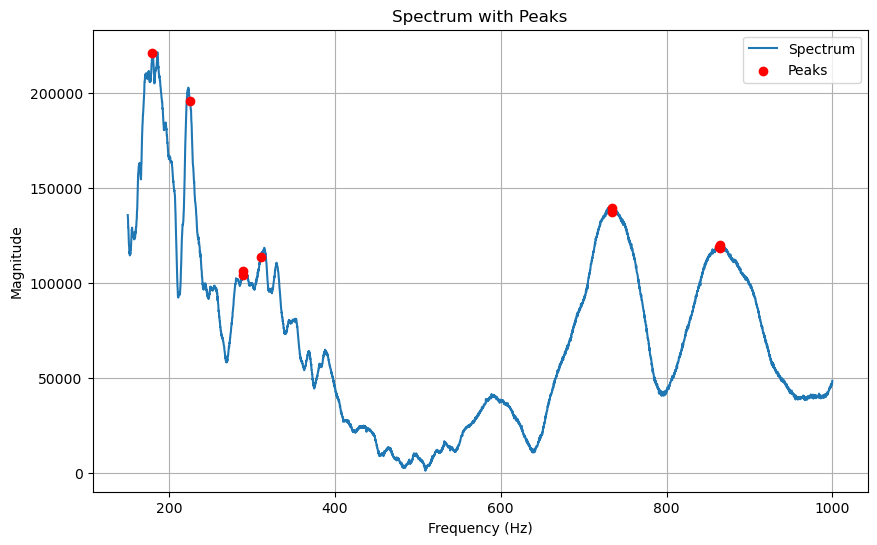

In [18]:
spectrum, freqs = spectrumFromSignal(testWavFileVect[0], samplerateVect[0])
peaks = X_peaksHz[0]
peaksAmplitude = X_peaksAmplitude[0]
print(peaks, peaksAmplitude)

# Map the peaks (frequencies) to their corresponding indices in the freqs array
peak_indices = [np.argmin(np.abs(freqs - peak)) for peak in peaks]

# Plot the spectrum with the peaks
plt.figure(figsize=(10, 6))
plt.plot(freqs[:len(spectrum)], spectrum, label="Spectrum")
plt.scatter(freqs[peak_indices], spectrum[peak_indices], color="red", label="Peaks", zorder=5)
plt.title("Spectrum with Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()


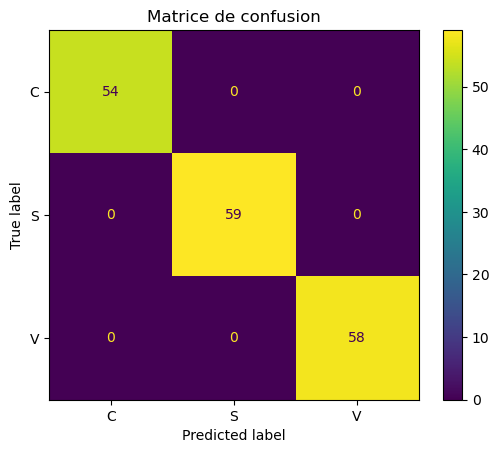

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
